In [7]:
#!pip install nltk
#!pip install datasets

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Dinh
[nltk_data]     Vinh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 1. Data preparation

In [10]:
from datasets import load_dataset

imdb = load_dataset("imdb")
train_data, test_data = imdb['train'], imdb['test']

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [11]:
# test
print(train_data.shape)
print(test_data.shape)

(25000, 2)
(25000, 2)


In [24]:
print(train_data[0]['text'])

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

In [25]:
print(train_data[0]['label'])

0


In [12]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


tokenizer = get_tokenizer("basic_english")
vocab_size = 20000

def yield_tokens(data_iter):
    for data in data_iter:
        yield tokenizer(data["text"])

vocab = build_vocab_from_iterator(yield_tokens(train_data),
                                  min_freq = 3,
                                  max_tokens=vocab_size,
                                  specials=["<pad>", "<s>", "<unk>"])
vocab.set_default_index(vocab["<unk>"]) # This index will be returned when OOV token is queried

In [13]:
seq_length = 500
text_pipeline = lambda x: vocab(tokenizer(x))

def collate_batch(batch, seq_length=500):
    text_list, label_list = [], []
    for sample in batch:
        label_list.append(sample['label'])
        
        text_processed = text_pipeline(sample['text'])[:seq_length]
        if len(text_processed) < seq_length:
            pad_size = seq_length - len(text_processed) -1
            text_processed = [vocab["<pad>"]] * pad_size + [vocab["<s>"]] + text_processed
        text_list.append(text_processed)

    input_ids = torch.tensor(text_list, dtype=torch.int64)
    labels = torch.tensor(label_list, dtype=torch.int64)
    return input_ids, labels

In [14]:
from torch.utils.data import DataLoader
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch, drop_last=True)

In [17]:
vocab["<s>"], vocab["<pad>"], vocab["<unk>"]

(1, 0, 2)

In [18]:
for inputs, labels in train_loader:
    sample = inputs[0]
    print(sample)
    break

tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

# 2. Model

In [26]:
class TextClsModel(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.RNN(emb_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.rnn(x)
        last_hidden = hidden[-1,:,:] 
        x = self.fc(last_hidden)
        return x


In [27]:
model = TextClsModel(vocab_size=vocab_size, 
                     emb_dim=128, 
                     hidden_dim=64,
                     num_layers=2
                     )

In [32]:
from torchsummary import summary

random_tensor = torch.randint(low=0, high=vocab_size, size=(64, seq_length), dtype=torch.long)
print('random_tensor:', random_tensor.shape)
summary(model, random_tensor)

random_tensor: torch.Size([64, 500])
Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding: 1-1                         [-1, 500, 128]            2,560,000
├─RNN: 1-2                               [-1, 500, 64]             20,736
├─Linear: 1-3                            [-1, 2]                   130
Total params: 2,580,866
Trainable params: 2,580,866
Non-trainable params: 0
Total mult-adds (M): 2.58
Input size (MB): 0.12
Forward/backward pass size (MB): 0.73
Params size (MB): 9.85
Estimated Total Size (MB): 10.70


Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding: 1-1                         [-1, 500, 128]            2,560,000
├─RNN: 1-2                               [-1, 500, 64]             20,736
├─Linear: 1-3                            [-1, 2]                   130
Total params: 2,580,866
Trainable params: 2,580,866
Non-trainable params: 0
Total mult-adds (M): 2.58
Input size (MB): 0.12
Forward/backward pass size (MB): 0.73
Params size (MB): 9.85
Estimated Total Size (MB): 10.70

# 3. Evaluate

In [9]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            test_loss += loss.item()
            correct +=(predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    accuracy = 100* correct / total

    return test_loss, accuracy

# 4. Train

In [10]:
device = 'cuda'
max_epoch = 20
LR = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [11]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

model.to(device)
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        loss.backward()
        optimizer.step()

    epoch_loss =  running_loss / len(train_loader)
    epoch_accuracy = 100* running_correct / total
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/20], Loss: 0.6798, Accuracy: 57.33%, Test Loss: 0.6311, Test Accuracy: 65.71%
Epoch [2/20], Loss: 0.6221, Accuracy: 65.94%, Test Loss: 0.6420, Test Accuracy: 62.90%
Epoch [3/20], Loss: 0.5785, Accuracy: 69.71%, Test Loss: 0.6244, Test Accuracy: 65.52%
Epoch [4/20], Loss: 0.5374, Accuracy: 73.33%, Test Loss: 0.6397, Test Accuracy: 66.32%
Epoch [5/20], Loss: 0.5250, Accuracy: 74.59%, Test Loss: 0.6464, Test Accuracy: 66.18%
Epoch [6/20], Loss: 0.5321, Accuracy: 74.30%, Test Loss: 0.6288, Test Accuracy: 67.60%
Epoch [7/20], Loss: 0.5214, Accuracy: 74.61%, Test Loss: 0.6534, Test Accuracy: 66.52%
Epoch [8/20], Loss: 0.5064, Accuracy: 75.93%, Test Loss: 0.6543, Test Accuracy: 66.41%
Epoch [9/20], Loss: 0.4855, Accuracy: 77.04%, Test Loss: 0.6207, Test Accuracy: 67.94%
Epoch [10/20], Loss: 0.4688, Accuracy: 78.00%, Test Loss: 0.6205, Test Accuracy: 67.78%
Epoch [11/20], Loss: 0.4684, Accuracy: 78.06%, Test Loss: 0.6268, Test Accuracy: 69.59%
Epoch [12/20], Loss: 0.4761, Accuracy: 77

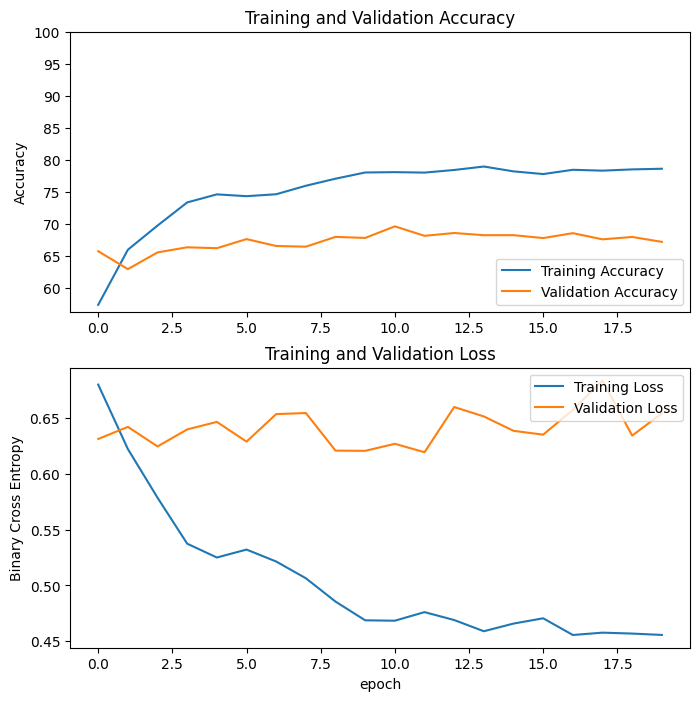

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),100])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()